# The Numerical Sandbox: Compression Experiment

**Romain Beucher** romain.beucher (at) anu.edu.au

The following notebook is an implementation of the Numerical Sandbox Compression Experiment similar to [Buiter et al., 2006](http://sp.lyellcollection.org/content/253/1/29). The test is commonly referred as one of the GEOMOD benchmarks and is used to test the large deformation viscous-plastic behaviour of geodynamic numerical codes.

![Tutorial4](./images/Tutorial4.png)

The initial purpose of the GEOMOD numerical experiments was to compare results from analog and numerical experiments. It is not a numerical benchmark sensus-stricto.

In [1]:
from underworld import UWGeodynamics as GEO

loaded rc file /opt/venv/lib/python3.7/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.u

## Scaling

In [3]:
velocity = 2.5 * u.centimeter / u.hour
model_length = 40. * u.centimeter
model_height = 10. * u.centimeter
refViscosity = 1e7 * u.pascal * u.second
bodyforce = 1560 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

# General parameters

In [4]:
Model = GEO.Model(elementRes=(200,50), 
                  minCoord=(0. * u.centimeter, -3.5 * u.centimeter), 
                  maxCoord=(40. * u.centimeter, 6.5 * u.centimeter))

In [5]:
Model.outputDir="outputs_tutorial4"

In [6]:
Model.minViscosity = 1.0e5 * u.pascal * u.second
Model.maxViscosity = 1e12 * u.pascal * u.second

In [7]:
Model.mesh_advector(axis=0)

# Initial Setup

# Model Geometry

The shortening experiment follows a more or less classic set-up used to study fold-and-thrust belt evolution with analogue models. Shortening is achieved by moving the right-hand wall inward while the left wall and base are held fixed. The model consists of ‘sand’ layers with an embedded 0.5 cm thick layer of weaker ‘microbeads'. Total height is 10 cm. The initial width of the model is 40 cm. At the right side an initial wedge 10 cm long with a 10 degrees surface slope overlies the model. This wedge slope is in the stable field for a sand wedge (as calculated for this set-up from Dahlen 1984; Zhao et al. 1986). The

<img src="images/CompressionSetUp.png" width=800>

We use a uniform resolution of 0.2 cm (400 x 100 elements)


## Material distribution

The way we choose do define the initial set up is based on the distribution of the different materials (or phases).

In [8]:
air        = Model.add_material(name="Air", shape=GEO.shapes.Layer2D(top=Model.top, bottom=0.0))
sand1      = Model.add_material(name="Sand1", shape=GEO.shapes.Layer2D(top=air.bottom, bottom=Model.bottom))
sand2      = Model.add_material(name="Sand2", shape=GEO.shapes.Layer2D(top=-1.0 * u.centimetre, bottom=-1.5*u.centimetre))
microbeads = Model.add_material(name="Microbeads", shape=GEO.shapes.Layer2D(top=-2.5 * u.centimetre, bottom=-3.0*u.centimetre))

import numpy as np

wedge = [( 30.* u.centimeter, 0. * u.centimeter),
         (Model.maxCoord[0], 10.*u.centimeter * np.tan(np.radians(10))),
         (Model.maxCoord[0], 0. * u.centimeter)]

sand3     = Model.add_material(name="Sand3", shape=GEO.shapes.Polygon(wedge))

## Passive Tracers

In [11]:
import numpy as np

npoints = 1000

coords = np.ndarray((npoints, 2))
coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords[:, 1] = GEO.nd(sand1.top)

Model.add_passive_tracers(name="Interface1", vertices=coords)

coords[:, 1] = GEO.nd(sand2.top)
Model.add_passive_tracers(name="Interface2", vertices=coords)

coords[:, 1] = GEO.nd(sand2.bottom)
Model.add_passive_tracers(name="Interface3", vertices=coords)

coords[:, 1] = GEO.nd(microbeads.top)
Model.add_passive_tracers(name="Interface4", vertices=coords)

coords[:, 1] = GEO.nd(microbeads.bottom)
Model.add_passive_tracers(name="Interface5", vertices=coords)


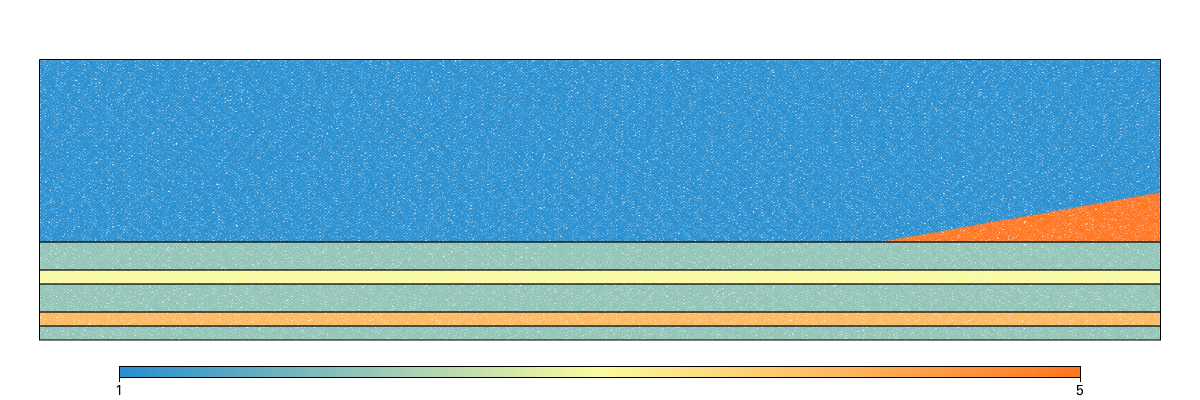

In [12]:
from underworld import visualisation as vis
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.Interface1_tracers, pointSize=2.0)
Fig.Points(Model.Interface2_tracers, pointSize=2.0)
Fig.Points(Model.Interface3_tracers, pointSize=2.0)
Fig.Points(Model.Interface4_tracers, pointSize=2.0)
Fig.Points(Model.Interface5_tracers, pointSize=2.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()

## Material properties

### Densities

In [13]:
air.density        = 10. * u.kilogram / u.metre**3
sand1.density      = 1560. * u.kilogram / u.metre**3
sand2.density      = 1560. * u.kilogram / u.metre**3
sand3.density      = 1560. * u.kilogram / u.metre**3
microbeads.density = 1480. * u.kilogram / u.metre**3

## Viscosities

In [14]:
air.viscosity        = 1.0e5 * u.pascal * u.second
sand1.viscosity      = 1.0e12 * u.pascal * u.second
sand2.viscosity      = 1.0e12 * u.pascal * u.second
sand3.viscosity      = 1.0e12 * u.pascal * u.second
microbeads.viscosity = 1.0e12 * u.pascal * u.second

## Plasticities

In [15]:
sandFriction = np.tan(np.radians(36.0))
sandFrictionW = np.tan(np.radians(31.0))

microbeadsFriction = np.tan(np.radians(22.0))
microbeadsFrictionW = np.tan(np.radians(21.0))

sand1.plasticity       = GEO.DruckerPrager(cohesion=10.*u.pascal, frictionCoefficient=sandFriction, frictionAfterSoftening=sandFrictionW)
sand2.plasticity       = GEO.DruckerPrager(cohesion=10.*u.pascal, frictionCoefficient=sandFriction, frictionAfterSoftening=sandFrictionW)
sand3.plasticity       = GEO.DruckerPrager(cohesion=10.*u.pascal, frictionCoefficient=sandFriction, frictionAfterSoftening=sandFrictionW)
microbeads.plasticity  = GEO.DruckerPrager(cohesion=10.*u.pascal, frictionCoefficient=microbeadsFriction, frictionAfterSoftening=microbeadsFrictionW)

In [16]:
import underworld.function as fn

conditions = [(Model.y < GEO.nd(Model.bottom +  0.2 * u.centimeter), 0.0),
              (Model.y > GEO.nd(Model.bottom +  0.4 * u.centimeter), GEO.nd(-2.5 * u.centimetre / u.hour)),
              (True, (GEO.nd(-2.5 * u.centimeter / u.hour) / GEO.nd(0.2 * u.centimeter) * (Model.y - GEO.nd(Model.bottom) - GEO.nd(0.2 * u.centimeter))))]

fn_condition = fn.branching.conditional(conditions)

In [17]:
Model.set_velocityBCs(left=[0.,0.], right=[fn_condition, 0.], bottom=[0.,0.])

In [18]:
A = Model.set_frictional_boundary(left=np.tan(np.radians(19.)), right=np.tan(np.radians(19.)), bottom=np.tan(np.radians(19.)), top=None, thickness=3)


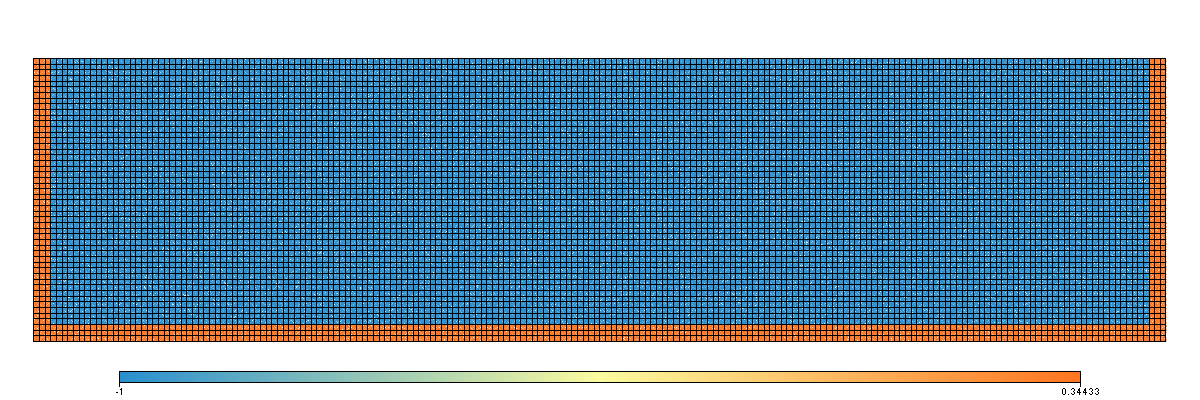

In [19]:
from underworld import visualisation as vis
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, A.friction, fn_size=2.0)
Fig.Mesh(Model.mesh)
Fig.show()

In [20]:
Model.init_model(pressure="lithostatic", temperature=None)
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)

In [ ]:
Model.run_for(2.0 * u.hour, checkpoint_interval=0.1*u.hour)


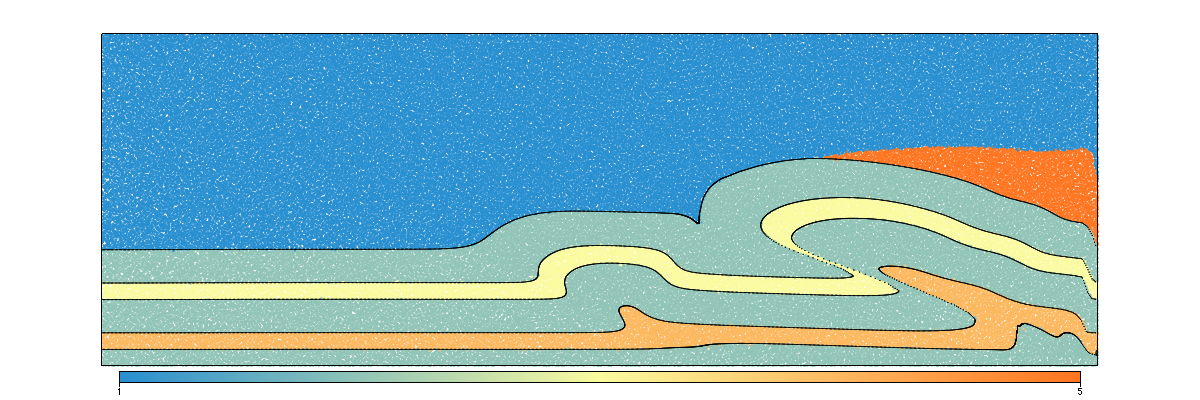

In [29]:
from underworld import visualisation as vis
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.Interface1_tracers, pointSize=2.0)
Fig.Points(Model.Interface1_tracers, pointSize=2.0)
Fig.Points(Model.Interface1_tracers, pointSize=2.0)
Fig.Points(Model.Interface1_tracers, pointSize=2.0)
Fig.Points(Model.Interface1_tracers, pointSize=2.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=3.0)
Fig.show()